# 1.このSprintについて

Sprintの目的
- フレームワークのコードを読めるようにする
- フレームワークを習得し続けられるようになる
- 理論を知っている範囲をフレームワークで動かす

どのように学ぶか
- 前半はTensorFlowのExampleを動かします。後半ではKerasのコードを書いていきます。

# 【問題1】公式チュートリアルモデルを分担して実行
TensorFLowの公式チュートリアルモデルを分担して実行してください。


以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。


[models/tutorials at master · tensorflow/models](https://www.tensorflow.org/tutorials/structured_data/time_series)

# 構造化データ：時系列予測（TensorFlow 2.0）
このチュートリアルは、リカレントニューラルネットワーク（RNN）を使用した時系列予測の概要です。  
これは 2 つのパートでカバーされます。最初に、単変量時系列を予測して、それから多変量時系列を予測します。

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## 気象データセット
このデータセットには、気温、大気圧、湿度などの14の異なる特徴が含まれています。  
これらは2003年以降、10分ごとに収集されました。  
2009年から2016年の間に収集されたデータのみを使用します。

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)

In [4]:
df.shape

(420551, 15)

In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


観測は10分ごとに記録されます。つまり、1時間で6つの観測値が得られます。  
同様に、1日には144（6x24）の観測が含まれます。

特定の時間から６時間後の気温を予測するとします。この予測を行うために、５日間の観測を使用します。したがって、モデルをトレーニングするために、最後の720（5×144）観測をを含むウィンドウを作成します。

以下の関数は、モデルが学習するための上記の時間枠を返します。  
`history_size`：過去の情報ウィンドウのサイズ。  
`Target_size`：モデルが予測を学習する必要がある将来の期間。（＝ラベル）

In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [118]:
dd = np.arange(1, 10).reshape(-1, 1)
a1, a2 = univariate_data(dd, 0, 5, 2, 0)
a1

array([[[1],
        [2]],

       [[2],
        [3]],

       [[3],
        [4]]])

In [119]:
a2

array([[3],
       [4],
       [5]])

次の両方のチュートリアルでは、データの最初の300,000行がトレーニングデータセットになり（約2100日分）、残りは検証データセットになります。

In [7]:
TRAIN_SPLIT = 300000

In [51]:
# 再現性を確保するためのシードの設定
tf.random.set_seed(13)

## Part 1:単変量時系列予測
最初に、単一の特徴（温度）のみを使用してモデルをトレーニングし、それを使用して将来のその値の予測を行います。  
まず、データセットから温度のみを抽出します。

In [9]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

このデータが時間の経過とともにどのように見えるかを見てみましょう。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8bd7456160>],
      dtype=object)

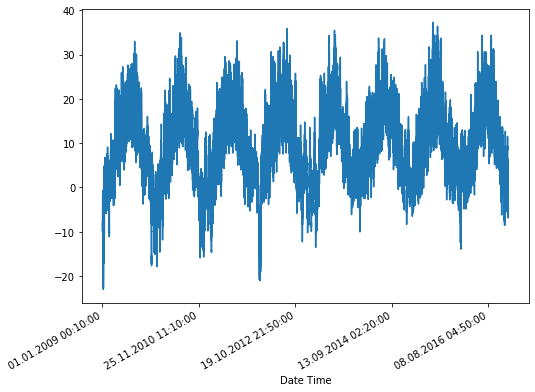

In [10]:
uni_data.plot(subplots=True)

In [11]:
uni_data = uni_data.values

### ニューラルネットワークをトレーニングする前に、機能をスケーリングすることが重要です。  
標準化は、平均を差し引き、各特徴の標準偏差で除算することにより、このスケーリングを行う一般的な方法です。値を[0,1]の範囲に再スケーリングするtf.keras.utils.normalizeメソッドを使用することもできます。

In [12]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [13]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

次に、単量モデルのデータを作成します。  
パート1の場合、モデルには最後の20個の記録された温度観測が与えられ、次のタイムステップで温度を予測することを学習する必要があります。

In [14]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

これは、univariate_data関数が返すものです。

In [15]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


データが作成されたので、1つの例を見てみましょう。  
ネットワークに提供される情報は青で表示され、赤十字の値を予測する必要があります。

In [16]:
def create_time_steps(length):
    return list(range(-length, 0))

In [17]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

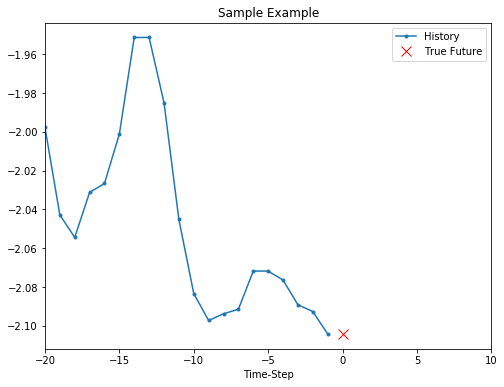

In [18]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example');

## ベースライン
モデルのトレーニングに進む前に、まず単純なベースラインを設定しましょう。  
入力ポイントが与えられると、ベースラインメソッドはすべての履歴を調べ、次のポイントを最後の20観測の平均であると予測します。

In [19]:
def baseline(history):
    return np.mean(history)

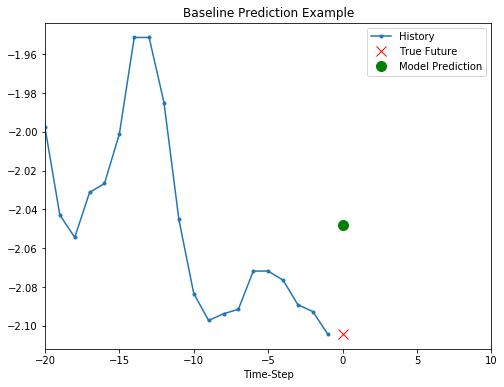

In [20]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example');

リカレントニューラルネットワークを使用して、このベースラインを打ち負かすことができるかどうか見てみましょう。
## リカレントニューラルネットワーク
再帰型ニューラルネットワーク（RNN）は、時系列データに適したタイプのニューラルネットワークです。  
RNNは時系列を段階的に処理し、これまでに見た情報を要約した内部状態を維持します。  
このチュートリアルでは、Long Short Term Memory（LSTM）と呼ばれる特殊なRNNレイヤーを使用します。  
次に、tf.dataを使用して、データセットをシャッフル、バッチ処理、キャッシュします。

In [52]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [22]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

サンプル予測を作成して、モデルの出力を確認してみましょう。

In [53]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


それではモデルをトレーニングしましょう。  
データセットのサイズが大きいため、時間を節約するために、通常行われる完全なトレーニングデータではなく、各エポックは200ステップだけ実行されます

In [24]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 30s 151ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 26s 131ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 23s 116ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 27s 133ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 24s 120ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 16s 81ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 19s 97ms/step - loss: 0.0286 - val_loss: 0.0206
Epoch 8/10
200/200 [==============================] - 16s 81ms/step - loss: 0.0263 - val_loss: 0.0197
Epoch 9/10
200/200 [==============================] - 24s 119ms/step - loss: 0.0253 - val_loss: 0.0182
Epoch 10/10
200/200 [============

## 単純なLSTMモデルを使用して予測する
簡単なLSTMをトレーニングしたので、いくつかの予測をしてみましょう。

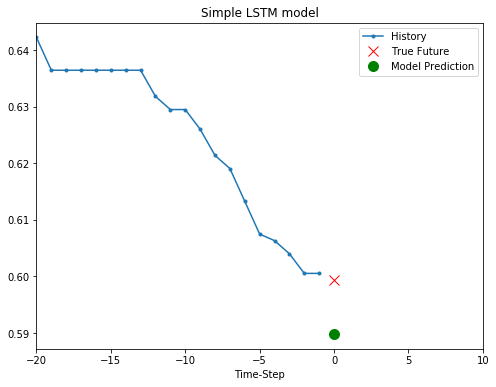

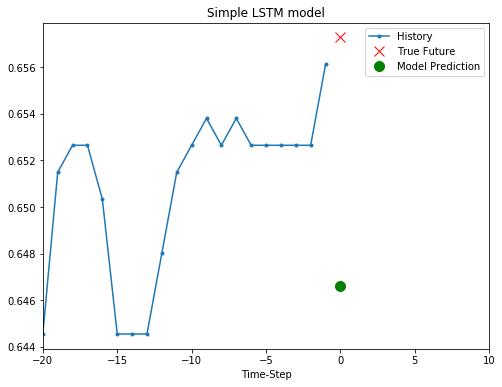

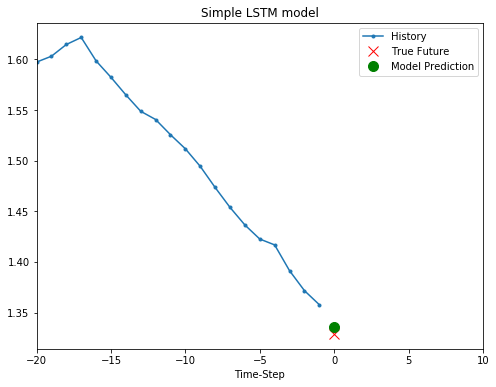

In [25]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

これはベースラインよりも良く見えます。  
基本を理解したところで、パート2に進みましょう。ここでは、多変量時系列を操作します。

# パート2：多変量時系列の予測
元のデータセットには14の特徴が含まれています。  
使用される機能は、気温、大気圧、および空気密度です。  
さらに多くの機能を使用するには、その名前をこのリストに追加します。

In [26]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [27]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


これらの各機能が時間の経過とともにどのように変化するかを見てみましょう

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8bb05a1710>,
      dtype=object)

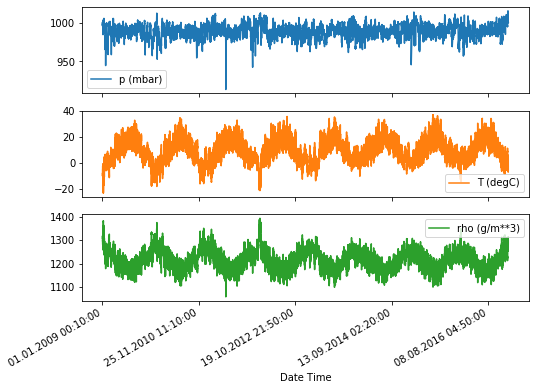

In [28]:
features.plot(subplots=True)

前述のように、最初のステップは、トレーニングデータの平均と標準偏差を使用してデータセットを標準化することです。

In [29]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [30]:
dataset = (dataset-data_mean)/data_std

## シングルステップモデル
シングルステップセットアップでは、モデルは、提供された履歴に基づいて将来の単一のポイントを予測することを学習します。  


以下の関数は、以下と同じウィンドウ処理タスクを実行しますが、ここでは、指定されたステップサイズに基づいて過去の観測値をサンプリングします。

In [31]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
        
    return np.array(data), np.array(labels)

このチュートリアルでは、ネットワークには過去5日間のデータが表示されます。つまり、1時間ごとにサンプリングされる720観測です。  
60分以内に大幅な変化が予想されないため、サンプリングは1時間ごとに行われます。  
したがって、120の観測は過去5日間の履歴を表します。  
シングルステップ予測モデルの場合、データポイントのラベルは12時間後の気温です。  
このためのラベルを作成するために、72（12 * 6）観測後の温度が使用されます。

In [32]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

単一のデータポイントを見てみましょう

In [33]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [34]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [35]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

サンプル予測をチェックしてみましょう。

In [36]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [37]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 133s 665ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 120s 602ms/step - loss: 0.2624 - val_loss: 0.2424
Epoch 3/10
200/200 [==============================] - 119s 594ms/step - loss: 0.2614 - val_loss: 0.2463
Epoch 4/10
200/200 [==============================] - 119s 596ms/step - loss: 0.2567 - val_loss: 0.2441
Epoch 5/10
200/200 [==============================] - 118s 591ms/step - loss: 0.2261 - val_loss: 0.2342
Epoch 6/10
200/200 [==============================] - 123s 613ms/step - loss: 0.2412 - val_loss: 0.2669
Epoch 7/10
200/200 [==============================] - 120s 601ms/step - loss: 0.2403 - val_loss: 0.2557
Epoch 8/10
200/200 [==============================] - 118s 592ms/step - loss: 0.2400 - val_loss: 0.2373
Epoch 9/10
200/200 [==============================] - 126s 630ms/step - loss: 0.2451 - val_loss: 0.2472
Epoch 10/10
200/200 [

In [38]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

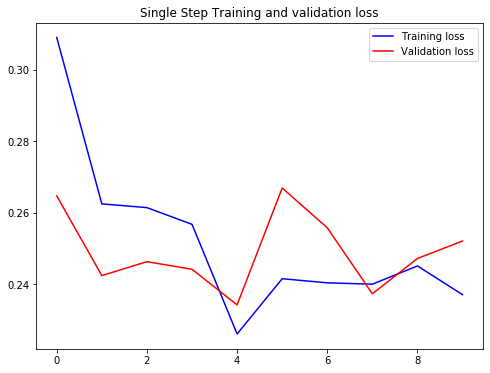

In [54]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

## 一歩先を予測する
モデルがトレーニングされたので、サンプル予測をいくつか行ってみましょう。  


モデルには、毎時サンプリングされた過去5日間の3つの特徴の履歴（120データポイント）が与えられます。目標は温度を予測することであるため、プロットは過去の温度のみを表示します。  


予測は1日後に行われます（そのため、履歴と予測の間のギャップがあります）。

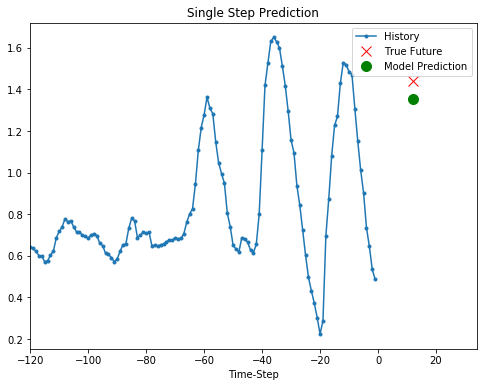

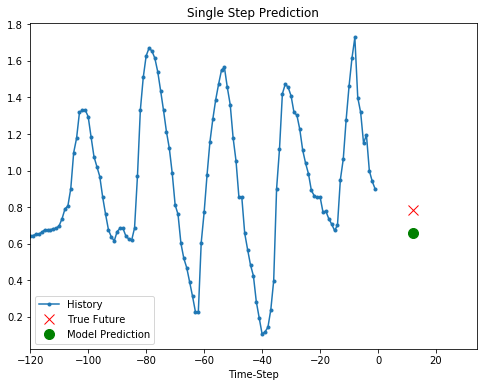

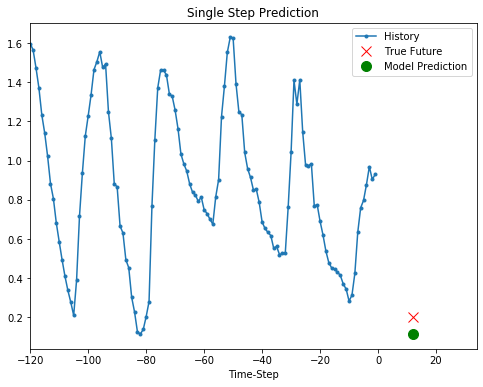

In [39]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

## マルチステップモデル
マルチステップ予測モデルでは、過去の履歴が与えられると、モデルは将来の値の範囲を予測することを学習する必要があります。したがって、単一の未来点のみが予測されるシングルステップモデルとは異なり、マルチステップモデルは未来のシーケンスを予測します。

マルチステップモデルの場合、トレーニングデータは、毎時間サンプリングされた過去5日間の記録で構成されます。ただし、ここでは、モデルは次の12時間の温度を予測することを学習する必要があります。観測は１０分ごとに行われるため、出力は７２予測です。

このタスクでは、それに応じてデータセットを準備する必要があります。したがって、最初のステップは、データセットをもう一度作成することですが、ターゲットウィンドウは異なります。

In [40]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

サンプルのデータポイントを確認してみましょう。

In [58]:
x_train_multi[0, 0]

array([ 0.95547359, -1.99766294,  2.2350791 ])

In [66]:
x_train_multi.shape

(299280, 120, 3)

In [65]:
y_train_multi[0, :3]

array([-2.54879807, -2.56616578, -2.58121779])

In [67]:
y_train_multi.shape

(299280, 72)

In [41]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [42]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

サンプルデータポイントのプロット。

In [43]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

このプロットとそれに続く同様のプロットでは、履歴と将来のデータが1時間ごとにサンプリングされます。

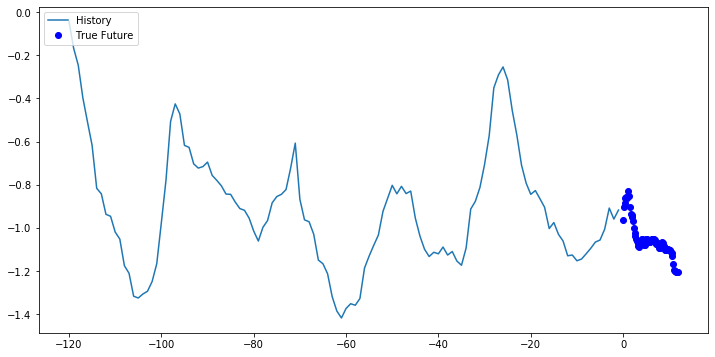

In [44]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

ここでのタスクは前のタスクよりも少し複雑であるため、モデルは2つのLSTMレイヤーで構成されています。  
最後に、72の予測が行われるため、出力層は72の予測を出力します。

In [45]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

トレーニングする前にモデルがどのように予測するか見てみましょう。

In [46]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 72)


In [47]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 220s 1s/step - loss: 0.4968 - val_loss: 0.3019
Epoch 2/10
200/200 [==============================] - 247s 1s/step - loss: 0.3479 - val_loss: 0.2854
Epoch 3/10
200/200 [==============================] - 273s 1s/step - loss: 7.9007 - val_loss: 0.2722
Epoch 4/10
200/200 [==============================] - 239s 1s/step - loss: 0.2897 - val_loss: 0.2156
Epoch 5/10
200/200 [==============================] - 244s 1s/step - loss: 0.2066 - val_loss: 0.2018
Epoch 6/10
200/200 [==============================] - 262s 1s/step - loss: 0.2094 - val_loss: 0.2113
Epoch 7/10
200/200 [==============================] - 252s 1s/step - loss: 0.2023 - val_loss: 0.2108
Epoch 8/10
200/200 [==============================] - 273s 1s/step - loss: 0.1983 - val_loss: 0.2075
Epoch 9/10
200/200 [==============================] - 245s 1s/step - loss: 0.2006 - val_loss: 0.1876
Epoch 10/10
200/200 [===========================

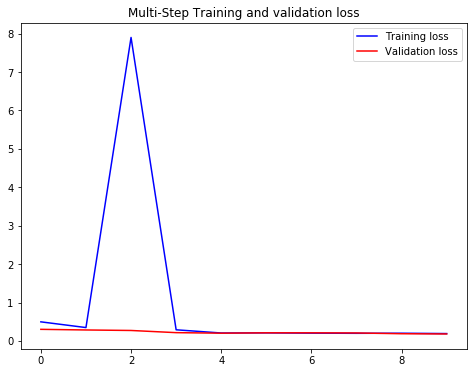

In [48]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

## マルチステップの未来を予測する
次に、ネットワークがどれだけうまく未来を予測することを学んだかを見てみましょう。

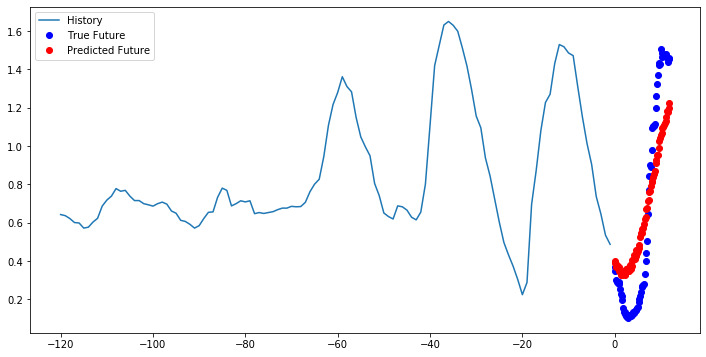

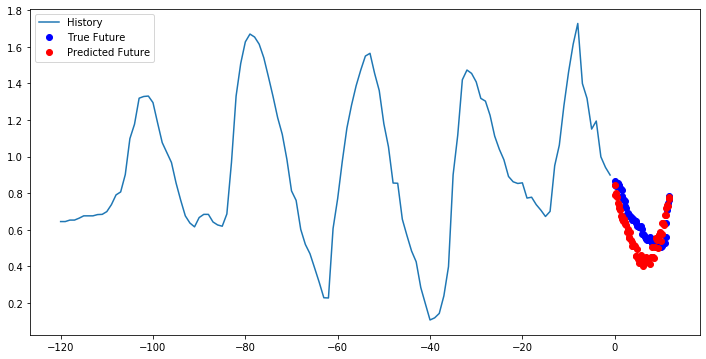

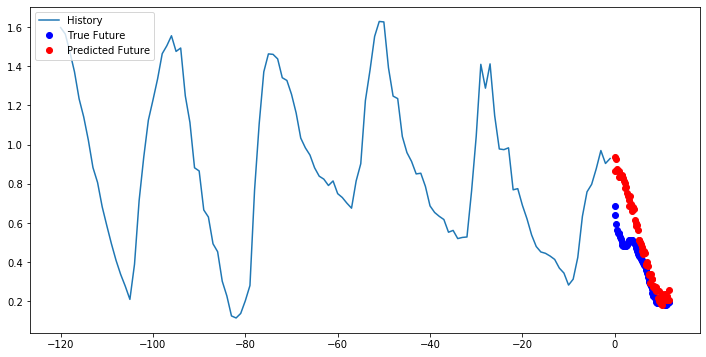

In [71]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

## 以上
## RNNを使用した時系列予測の簡単な紹介でした。

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


# 【問題3】Iris（2値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する2値分類をKerasに書き換えてください。

In [2]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)

# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [3]:
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation = tf.nn.sigmoid))




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=10,
                    verbose=1,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                250       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 5,451
Trainable params: 5,451
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 64 samples, validate on 16 samples
Epoch 1/10
64/64 [==============================] - 1s 15ms/sample - loss: 1.1083 - acc: 0.4375 - val_loss: 0.6980 - val_acc: 0.6250
Epoch 2/10
64/64 [==============================] - 0s 704us/sample - loss: 0.6719 - acc: 0.6719 - val_loss: 0.74

In [5]:
y_pred_proba = model.predict(X_test)[:, 0]
# 確率を0, 1に変換
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

y_pred_proba [0.01028347 0.9700726  0.01304066 0.86462325 0.43823427 0.93324375
 0.20511031 0.2826988  0.95340157 0.62816435 0.8169179  0.86527467
 0.9142822  0.06754318 0.00732011 0.00871563 0.12484887 0.00414601
 0.5111527  0.0063462 ]
y_pred [0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 0 0 0 1 0]
y_test [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0]


In [6]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.22405782341957092
Train accuracy: 0.85


# 【問題4】Iris（多値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する3値分類をKerasに書き換えてください。

In [7]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)

# データフレームから条件抽出
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

# ラベルを数値に変換
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# ワンホットエンコーディング
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train)
y_val_one_hot = enc.transform(y_val)
y_test_one_hot = enc.transform(y_test)

In [8]:
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))

In [9]:
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=['accuracy'])
history = model.fit(X_train, y_train_one_hot,
                    batch_size=10,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val, y_val_one_hot))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                250       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 5,653
Trainable params: 5,653
Non-trainable params: 0
_________________________________________________________________


In [10]:
y_pred_proba = model.predict(X_test)
# 確率を0, 1, 2に変換
y_pred = np.argmax(y_pred_proba, axis=1)
# print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

y_pred [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 2 0 0 2 0 0 1 1 0]
y_test [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]


In [11]:
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.10386975109577179
Train accuracy: 0.96666664


# 【問題5】House PricesをKerasで学習
TensorFlowによるHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [12]:
# データの読み込み
train = pd.read_csv('../kaggledata/train.csv')

x = train[['GrLivArea', 'YearBuilt']]
y = train[['SalePrice']]

# 対数変換
x = np.log(x).values
y = np.log(y).values

# 標準化
sc = StandardScaler()
sc.fit_transform(x)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [13]:
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(2,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation = tf.keras.activations.linear))

In [14]:
model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model.compile(loss='mse',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=['mse'])
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=20,
                    verbose=1,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                150       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 5,351
Trainable params: 5,351
Non-trainable params: 0
_________________________________________________________________
Train on 934 samples, validate on 234 samples
Epoch 1/20
934/934 [==============================] - 2s 2ms/sample - loss: 2.8348 - mean_squared_error: 2.8348 - val_loss: 0.0767 - val_mean_squared_error: 0.0767
Epoch 2/20
934/934 [==============================] - 0s 403us/sample - loss: 0.0933 - mean_squared_error: 0.0933 - val_loss: 0.0814 - val_mean_squared_error: 0.0814
Epoch 3/

In [15]:
y_pred_proba = model.predict(X_test)
# 確率を0, 1, 2に変換
y_pred = y_pred_proba
# print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred.ravel()[:5])
print('y_test', y_test.ravel()[:5])

y_pred [12.529852 12.126415 11.898547 12.351409 11.824139]
y_test [12.20918779 11.79810441 11.60823564 12.16525065 11.38509209]


In [16]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test MSE:', score[1])

Test loss: 0.06960799106179852
Test MSE: 0.069607995


# 【問題6】MNISTをKerasで学習
TensorFlowによるMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [162]:
# データセット読み込み
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 標準化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# ワンホットエンコーディング
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [163]:
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(784,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax))

In [164]:
%%time
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.005),
              metrics=['accuracy'])
history = model.fit(X_train, y_train_one_hot,
                    batch_size=20,
                    epochs=5,
                    verbose=1,
                    validation_data=(X_val, y_val_one_hot))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 45,360
Trainable params: 45,360
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 33s 694us/sample - loss: 0.2909 - acc: 0.9128 - val_loss: 0.2191 - val_acc: 0.9387
Epoch 2/5
48000/48000 [==============================] - 29s 614us/sample - loss: 0.1894 - acc: 0.9449 - val_loss: 0.1773 - val_acc: 0.9473
Epoch 3/5
48000/48000 [=============================

In [165]:
y_pred_proba = model.predict(X_test)

y_pred = np.argmax(y_pred_proba, axis=1)

print("y_pred", y_pred[:10])
print('y_test', y_test.ravel()[:10])

y_pred [7 2 1 0 4 1 4 9 5 9]
y_test [7 2 1 0 4 1 4 9 5 9]


In [166]:
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15124792428724468
Test accuracy: 0.9595


# 【問題7】（アドバンス課題）PyTorchへの書き換え
4種類の問題をPyTorchに書き換えてください。

# ・２値分類

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [31]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)

# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [32]:
# tensor型に変換
train_X = torch.Tensor(X_train)
val_X = torch.Tensor(X_val)
train_y = torch.LongTensor(y_train.ravel())
val_y = torch.LongTensor(y_val.ravel())

In [33]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.manual_seed(71) #seed固定、ネットワーク定義前にする必要ありそう
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)


In [34]:
#学習
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.02)
train_loss = []
train_accu = []
i = 0
model.train() #学習モード
for epoch in range(100):
    data, target = Variable(train_X), Variable(train_y)#微分可能な型
    optimizer.zero_grad() #勾配初期化
    output = model(data) #データを流す
        
    loss = F.nll_loss(output, target) #loss計算
    loss.backward()    #バックプロパゲーション
    train_loss.append(loss.data.item())
    optimizer.step()   # 重み更新
        
    prediction = output.data.max(1)[1] #予測結果
    accuracy = prediction.eq(target.data).sum().numpy() / len(train_X) #正解率
    train_accu.append(accuracy)
    
    if i % 10 == 0:
        print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data.item(), accuracy))
    i += 1
    
print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data.item(), accuracy))

Train Step: 0	Loss: 0.685	Accuracy: 0.531
Train Step: 10	Loss: 0.658	Accuracy: 0.531
Train Step: 20	Loss: 0.644	Accuracy: 0.531
Train Step: 30	Loss: 0.627	Accuracy: 0.578
Train Step: 40	Loss: 0.609	Accuracy: 0.625
Train Step: 50	Loss: 0.589	Accuracy: 0.734
Train Step: 60	Loss: 0.566	Accuracy: 0.766
Train Step: 70	Loss: 0.541	Accuracy: 0.828
Train Step: 80	Loss: 0.512	Accuracy: 0.859
Train Step: 90	Loss: 0.484	Accuracy: 0.938
Train Step: 100	Loss: 0.457	Accuracy: 0.938


In [35]:
#精度検証
model.eval() #推論モード
outputs = model(Variable(val_X))
_, predicted = torch.max(outputs.data, 1)
print('Accuracy: {:.3f}'.format(predicted.eq(val_y).sum().numpy() / len(predicted)))

Accuracy: 0.938


# ・多値分類

In [85]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)

# データフレームから条件抽出
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

# ラベルを数値に変換
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [86]:
# tensor型に変換
train_X = torch.Tensor(X_train)
val_X = torch.Tensor(X_val)
train_y = torch.LongTensor(y_train.ravel())
val_y = torch.LongTensor(y_val.ravel())

In [87]:
torch.manual_seed(71) #seed固定、ネットワーク定義前にする必要ありそう
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 3)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


In [88]:
#学習
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.02)
train_loss = []
train_accu = []
i = 0
model.train() #学習モード
for epoch in range(100):
    data, target = Variable(train_X), Variable(train_y)#微分可能な型
    optimizer.zero_grad() #勾配初期化
    output = model(data) #データを流す
        
    loss = F.nll_loss(output, target) #loss計算
    loss.backward()    #バックプロパゲーション
    train_loss.append(loss.data.item())
    optimizer.step()   # 重み更新
        
    prediction = output.data.max(1)[1] #予測結果
    accuracy = prediction.eq(target.data).sum().numpy() / len(train_X) #正解率
    train_accu.append(accuracy)
    
    if i % 10 == 0:
        print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data.item(), accuracy))
    i += 1
    
print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data.item(), accuracy))

Train Step: 0	Loss: 1.173	Accuracy: 0.312
Train Step: 10	Loss: 0.950	Accuracy: 0.552
Train Step: 20	Loss: 0.842	Accuracy: 0.688
Train Step: 30	Loss: 0.736	Accuracy: 0.688
Train Step: 40	Loss: 0.644	Accuracy: 0.688
Train Step: 50	Loss: 0.572	Accuracy: 0.698
Train Step: 60	Loss: 0.517	Accuracy: 0.719
Train Step: 70	Loss: 0.474	Accuracy: 0.781
Train Step: 80	Loss: 0.439	Accuracy: 0.833
Train Step: 90	Loss: 0.410	Accuracy: 0.875
Train Step: 100	Loss: 0.386	Accuracy: 0.917


In [91]:
#精度検証
model.eval() #推論モード
outputs = model(Variable(val_X))
_, predicted = torch.max(outputs.data, 1)
print('Accuracy: {:.3f}'.format(predicted.eq(val_y).sum().numpy() / len(predicted)))

Accuracy: 0.833


# ・House Prices

In [79]:
# データの読み込み
train = pd.read_csv('../kaggledata/train.csv')

x = train[['GrLivArea', 'YearBuilt']]
y = train[['SalePrice']]

# 対数変換
x = np.log(x).values
y = np.log(y).values

# 標準化
sc = StandardScaler()
sc.fit_transform(x)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [80]:
# tensor型に変換
train_X = torch.Tensor(X_train)
val_X = torch.Tensor(X_val)
train_y = torch.Tensor(y_train)
val_y = torch.Tensor(y_val)

In [81]:
torch.manual_seed(71) #seed固定、ネットワーク定義前にする必要ありそう
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = Net()
criterion = nn.MSELoss()
print(model)

Net(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)


In [82]:
#学習
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001)
train_loss = []
train_accu = []
i = 0
model.train() #学習モード
for epoch in range(100):
    data, target = Variable(train_X), Variable(train_y)#微分可能な型
    optimizer.zero_grad() #勾配初期化
    output = model(data) #データを流す
    
    loss = criterion(output, target) #loss計算
    loss.backward()    #バックプロパゲーション
    train_loss.append(loss.data.item())
    optimizer.step()   # 重み更新
    
    prediction = output #予測結果
    train_accu.append(accuracy)
    
    if i % 10 == 0:
        print('Train Step: {}\tMSE: {:.3f}'.format(i, loss.data.item()))
    i += 1
    
print('Train Step: {}\tMSE: {:.3f}'.format(i, loss.data.item()))

Train Step: 0	MSE: 152.530
Train Step: 10	MSE: 0.072
Train Step: 20	MSE: 0.072
Train Step: 30	MSE: 0.072
Train Step: 40	MSE: 0.072
Train Step: 50	MSE: 0.072
Train Step: 60	MSE: 0.072
Train Step: 70	MSE: 0.072
Train Step: 80	MSE: 0.072
Train Step: 90	MSE: 0.072
Train Step: 100	MSE: 0.072


In [83]:
prediction.flatten()[:5]

tensor([11.7658, 12.3025, 12.0814, 12.1506, 12.0299], grad_fn=<SliceBackward>)

In [84]:
train_y.flatten()[:5]

tensor([11.8451, 11.7753, 12.4842, 12.1479, 12.1007])

# ・MNIST

In [126]:
import math
import matplotlib.pyplot as plt

In [167]:
class MNISTDataset(Dataset):
    def __init__(self):
        from keras.datasets import mnist
        (X_train, y_train), (X_test, y_test) = mnist.load_data()

        # 標準化
        X_train = X_train.reshape(-1, 784)
        X_test = X_test.reshape(-1, 784)

        # 前処理
        X_train = X_train.astype(np.float)
        X_test = X_test.astype(np.float)
        X_train /= 255
        X_test /= 255

        # 分割
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
        
        self.x_data = torch.FloatTensor(X_train)
        self.x_test = torch.FloatTensor(X_val)
        self.y_data = torch.LongTensor(y_train)
        self.y_test = torch.LongTensor(y_val)
        
        self.datalen = len(self.y_data)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.datalen

In [168]:
batch_size = 20
dataset = MNISTDataset()
trainloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
epochs = 5
loss_list = []
total_samples = len(dataset)
n_iterations = math.ceil(total_samples / batch_size)

In [169]:
class Model(nn.Module):
    def __init__(self, in_featrues=784, h1=100, h2=50, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_featrues, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [170]:
torch.manual_seed(3)
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [171]:
%%time
for epoch in range(epochs):
    for i, data in enumerate(trainloader):
        inputs, labels = data
#         print(f'epoch:{epoch+1}/{epochs}, Iteration {i+1}/{n_iterations}, Inputs {inputs.shape}, Labels {labels.shape}')
        
        y_pred = model(inputs)
        loss = criterion(y_pred, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    pred = model(dataset.x_data)
    prediction = pred.data.max(1)[1] #予測結果
    accuracy = prediction.eq(dataset.y_data).sum().numpy() / len(dataset.y_data) #正解率
    loss_ = criterion(pred, dataset.y_data)
    
    print('epoch: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(epoch+1, loss_.data.item(), accuracy))

epoch: 1	Loss: 0.183	Accuracy: 0.943
epoch: 2	Loss: 0.126	Accuracy: 0.964
epoch: 3	Loss: 0.086	Accuracy: 0.974
epoch: 4	Loss: 0.076	Accuracy: 0.978
epoch: 5	Loss: 0.099	Accuracy: 0.970
CPU times: user 51.1 s, sys: 2.8 s, total: 53.9 s
Wall time: 1min 16s


In [172]:
with torch.no_grad():
    predicted_y = model.forward(dataset.x_test)
    loss = criterion(predicted_y, dataset.y_test)
    acc = predicted_y.argmax(axis=1)
    acc = acc.eq(dataset.y_test).sum().numpy() / len(dataset.y_test)
print(loss.item())
print(acc)

0.18635019659996033
0.9541666666666667


# 【問題8】（アドバンス課題）フレームワークの比較
それぞれのフレームワークにはどのような違いがあるかをまとめてください。


《視点例》


- 計算速度
- コードの行数・可読性
- 用意されている機能

## 解答
- kerasは実装が簡単。sklearnと共通する部分が多く扱いやすい。行数が少ない。
- pytorchは実装がめんどうだが、透過性とカスタマイズ性に優れており、開発者に好まれる？行数が多い。
- MNISTデータセットの実行時間ではKeras約２分、PyTorch約１分であった。